# Imports and libraries

please run pip install -r requirements.txt <br>
please ensure the whole project is under the path 'Group10_project' case sensitive <br>
'i.e. ..\\Group10_project\\src\\'

In [46]:
import os

import numpy as np

import pandas as pd
pd.options.display.float_format = "{:,.2f}".format

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, RegressorMixin

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

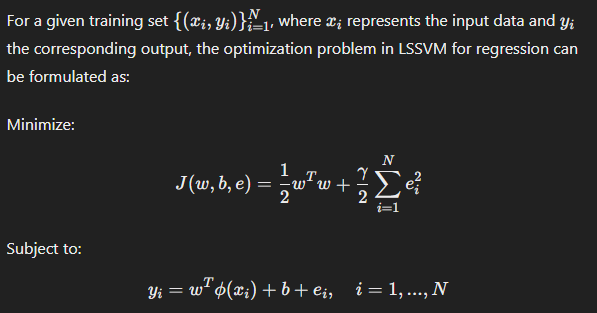

In [47]:
def getProjectRoot():
    REPO_NAME = "Group10_project"
    currentPath = os.getcwd()
    projectRoot = currentPath.split(REPO_NAME)[0] + REPO_NAME +"\\"

    return projectRoot

def getDataPaths(dataPath):
    for root, dirs, files in os.walk(dataPath):
        for file in files:
            # Get the full path to the file
            file_path = os.path.join(root, file)
            print(file_path)


## data processing helpers


In [48]:
def get_date_range_split(df, start_date, end_date, target_column, date_column = "DATETIME"):
    if date_column:
        df[date_column] = pd.to_datetime(df[date_column])
        df_filtered = df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]
    else:
        df.index = pd.to_datetime(df.index)
        df_filtered = df[(df.index >= start_date) & (df.index <= end_date)]

    # Split into X_test and y_test
    X_test = df_filtered.drop(columns=[target_column, date_column])
    y_test = df_filtered[target_column]
    
    X_test = X_test.to_numpy()
    scaler = StandardScaler()
    X_test = scaler.fit_transform(X_test)

    return X_test, y_test

## post-prediction helpers

In [49]:
def getEvaluationMetrics(y_test, y_pred, target):
    total_demand_mean = target.mean()

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rrmse = rmse / total_demand_mean
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Calculate Willmott's Index of Agreement (WI)
    def willmott_index(y_true, y_pred):
        mean_observed = np.mean(y_true)
        numerator = np.sum((y_true - y_pred) ** 2)
        denominator = np.sum((np.abs(y_pred - mean_observed) + np.abs(y_true - mean_observed)) ** 2)
        return 1 - (numerator / denominator)

    wi = willmott_index(y_test, y_pred)

    # Calculate Nash–Sutcliffe Efficiency (NSE) coefficient
    def nash_sutcliffe_efficiency(y_true, y_pred):
        mean_observed = np.mean(y_true)
        numerator = np.sum((y_true - y_pred) ** 2)
        denominator = np.sum((y_true - mean_observed) ** 2)
        return 1 - (numerator / denominator)

    nse = nash_sutcliffe_efficiency(y_test, y_pred)

    print(f'MAE: {mae:.2f}')
    print(f'Mean Squared Error (Regression): {mse:.2f}')
    print(f'R^2 Score (Regression): {r2:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'RRMSE: {rrmse:.2f}')
    print(f'Nash–Sutcliffe efficiency coefficient: {nse:.2f}')
    print(f'Willmott index: {wi:.2f}')
    print(f'MAPE is: {mape:.2f}')

def getPlots(y_test, y_pred, residuals = False):
    # plots
    # pred vs actual
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(y_test)), y_test, label='Actual', color='b')
    plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted', color='r')
    plt.xlabel('Time')
    plt.ylabel('Total Demand')
    plt.title('LSSVM Time Series Forecasting - Actual vs Predicted')
    plt.legend()
    plt.show()

    if(residuals):
        # residuals
        residuals = y_test - y_pred
        plt.figure(figsize=(12, 6))
        plt.plot(np.arange(len(residuals)), residuals, label='Residuals', color='g')
        plt.axhline(0, color='k', linestyle='--')
        plt.xlabel('Time')
        plt.ylabel('Residuals')
        plt.title('Residuals of LSSVM Time Series Forecasting')
        plt.show()

## LSSVM Classes

In [50]:
class LSSVMRegressor:
    def __init__(self, gamma=1.0, kernel='linear', sigma=1.0):
        self.gamma = gamma
        self.kernel = kernel
        self.sigma = sigma

    def _linear_kernel(self, X1, X2):
        return np.dot(X1, X2.T)

    def _rbf_kernel(self, X1, X2):
        sq_dists = np.sum(X1**2, axis=1).reshape(-1,1) + \
                   np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
        return np.exp(-sq_dists / (2 * self.sigma**2))

    def fit(self, X, y):
        n_samples = X.shape[0]
        y = y.reshape(-1, 1)
        if self.kernel == 'linear':
            K = self._linear_kernel(X, X)
        elif self.kernel == 'rbf':
            K = self._rbf_kernel(X, X)

        Omega = K + np.eye(n_samples) / self.gamma

        # Construct matrices for the linear system
        ones = np.ones((n_samples, 1))
        A = np.block([[0, ones.T],
                      [ones, Omega]])
        B = np.vstack([0, y])

        # Solve the linear system
        solution = np.linalg.solve(A, B)
        self.b = solution[0]
        self.alpha = solution[1:].flatten()
        self.X_train = X

    def predict(self, X):
        if self.kernel == 'linear':
            K = self._linear_kernel(X, self.X_train)
        elif self.kernel == 'rbf':
            K = self._rbf_kernel(X, self.X_train)
        predictions = np.dot(K, self.alpha) + self.b
        return predictions.flatten()

# Wrapper for GridSearchCV
class LSSVMRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, gamma=1.0, kernel='linear', sigma=1.0):
        self.gamma = gamma
        self.kernel = kernel
        self.sigma = sigma
        self.model = LSSVMRegressor(gamma=self.gamma, kernel=self.kernel, sigma=self.sigma)

    def fit(self, X, y):
        self.model.gamma = self.gamma
        self.model.kernel = self.kernel
        self.model.sigma = self.sigma
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Data assets

In [51]:
projRoot = getProjectRoot()
print(getDataPaths(projRoot + "\\data\\"))
print(getDataPaths(projRoot + "\\extracted_data\\"))

f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\Australia\a.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\Australia\b.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\Australia\c.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\Australia\d.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\forecastdemand_nsw.csv.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\forecastdemand_nsw.csv.zip.partaa
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\forecastdemand_nsw.csv.zip.partab
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\temperature_nsw.csv.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\totaldemand_nsw.csv.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\SILO\40842 BRISBANE.csv
f:\UNSW Master of Data Science\ZZSC9020

# Data loading

In [52]:
rollingWindowNSW = pd.read_csv(projRoot + "data\\SILO\\NSW_Rolling_Data.csv")
rollingWindowNSW = rollingWindowNSW.dropna()
print(rollingWindowNSW.shape)
rollingWindowNSW.columns

(4091, 19)


Index(['DATETIME', 'TOTALDEMAND', 'TEMPERATURE', 'Rain', 'Evap', 'Radn', 'VP',
       'RH', 'bushfire', 'flood', 'temp_change', 'high_temp_change',
       'humid_change', 'high_humid_change', 'rain_change', 'high_rain_change',
       'high_humid_past_week', 'high_rain_past_week', 'high_temp_past_week'],
      dtype='object')

In [53]:

rollingWindowQLD = pd.read_csv(projRoot + "data\SILO\QLD_Rolling_Data.csv")
rollingWindowQLD = rollingWindowQLD.dropna()
print(rollingWindowQLD.shape)
rollingWindowQLD.columns

(4087, 19)


Index(['DATETIME', 'TOTALDEMAND', 'TEMPERATURE', 'Rain', 'Evap', 'Radn', 'VP',
       'RH', 'bushfire', 'flood', 'temp_change', 'high_temp_change',
       'humid_change', 'high_humid_change', 'rain_change', 'high_rain_change',
       'high_humid_past_week', 'high_rain_past_week', 'high_temp_past_week'],
      dtype='object')

In [54]:
dailyMergedNSW = pd.read_csv(projRoot + "data\\SILO\\daily_merged_nsw.csv")
dailyMergedNSW = dailyMergedNSW.dropna()
dailyMergedNSW['DATETIME'] = pd.to_datetime(dailyMergedNSW['DATETIME'])
print(dailyMergedNSW.shape)
data = dailyMergedNSW
data.columns

(4092, 8)


Index(['DATETIME', 'TOTALDEMAND', 'TEMPERATURE', 'Rain', 'Evap', 'Radn', 'VP',
       'RH'],
      dtype='object')

data considered loaded at this point checking the data for anychanges made before continuing

In [55]:
data.describe()

,TOTALDEMAND,TEMPERATURE,Rain,Evap,Radn,VP,RH
count,"4,092.00","4,092.00","4,092.00","4,092.00","4,092.00","4,092.00","4,092.00"
mean,"8,112.78",17.41,2.32,4.19,16.00,14.17,68.08
std,798.86,4.69,8.28,2.31,7.42,4.79,10.60
min,"6,043.80",4.94,0.00,0.30,1.00,4.00,19.70
25%,"7,557.31",13.47,0.00,2.40,10.50,10.10,63.10
50%,"8,062.48",17.58,0.00,3.70,14.70,13.80,69.40
75%,"8,649.08",21.15,0.40,5.70,21.40,18.00,74.60
max,"11,539.82",33.31,159.60,16.00,34.40,27.90,96.25


# Exploratory data analysis

EDA of the DataFrame 'data' is performed here. No transformations or modifications are made during this stage

## Data summary

In [56]:
summary_stats = data.describe()
summary_stats

,TOTALDEMAND,TEMPERATURE,Rain,Evap,Radn,VP,RH
count,"4,092.00","4,092.00","4,092.00","4,092.00","4,092.00","4,092.00","4,092.00"
mean,"8,112.78",17.41,2.32,4.19,16.00,14.17,68.08
std,798.86,4.69,8.28,2.31,7.42,4.79,10.60
min,"6,043.80",4.94,0.00,0.30,1.00,4.00,19.70
25%,"7,557.31",13.47,0.00,2.40,10.50,10.10,63.10
50%,"8,062.48",17.58,0.00,3.70,14.70,13.80,69.40
75%,"8,649.08",21.15,0.40,5.70,21.40,18.00,74.60
max,"11,539.82",33.31,159.60,16.00,34.40,27.90,96.25


## Time series plot

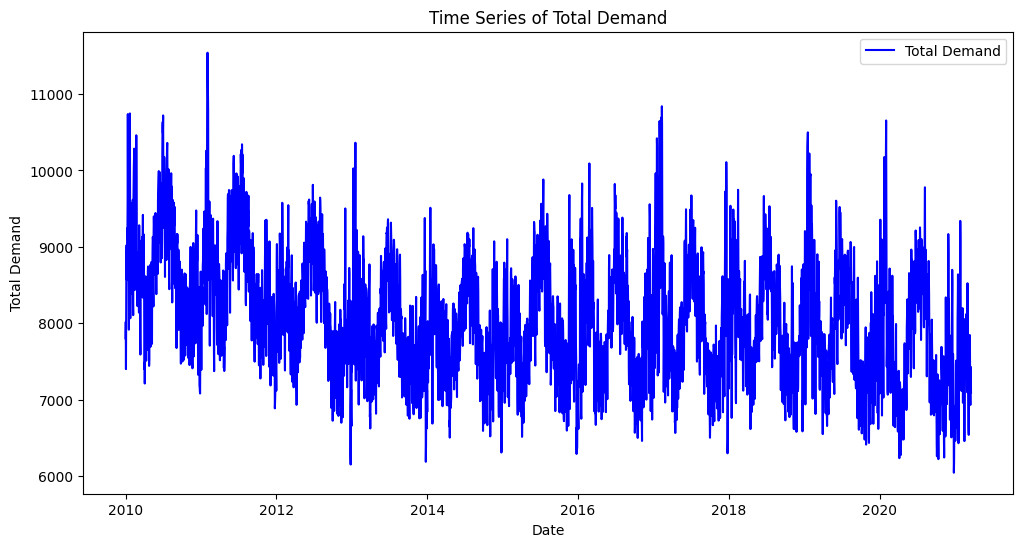

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(data['DATETIME'], data['TOTALDEMAND'], label='Total Demand', color='b')
plt.xlabel('Date')
plt.ylabel('Total Demand')
plt.title('Time Series of Total Demand')
plt.legend()
plt.show()


## Correlation map

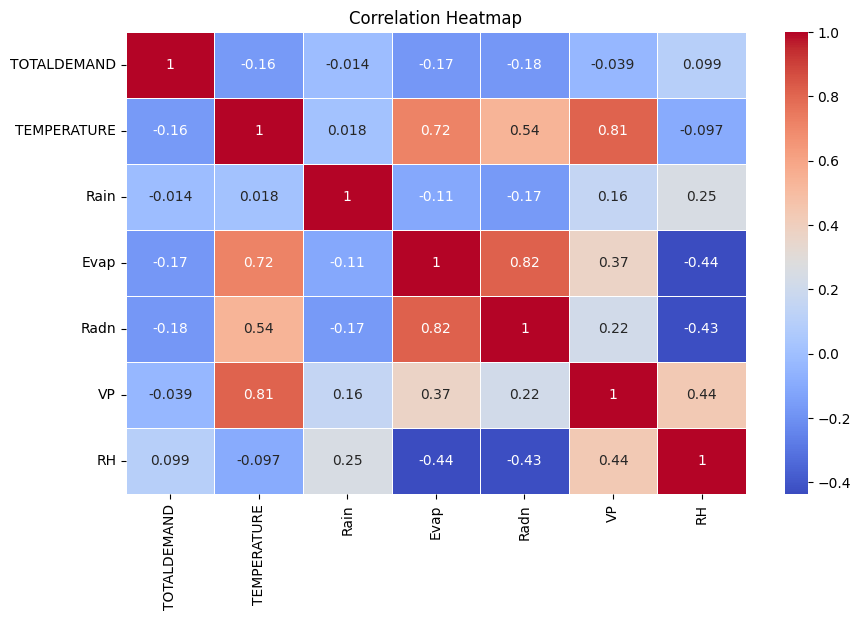

In [58]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## Autocorrelation and partial autocorrelation for TOTALDEMAND

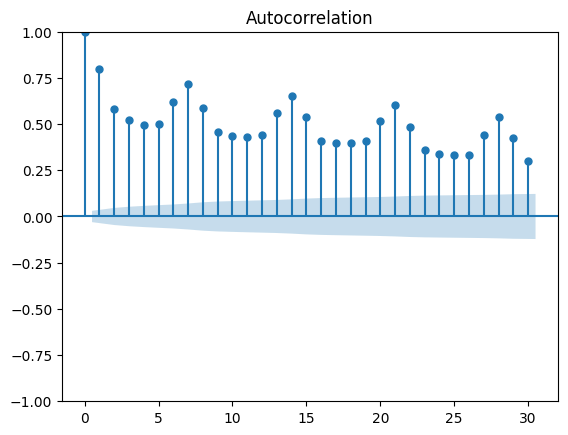

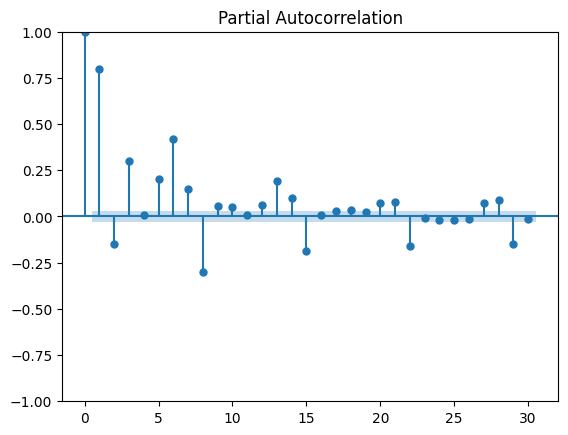

In [59]:
plot_acf(data['TOTALDEMAND'], lags=30)
plot_pacf(data['TOTALDEMAND'], lags=30)
plt.show()

## Feature engineering

Based on EDA the DataFrame 'data' is modified with engineered features

In [64]:
data.describe()

,TOTALDEMAND,TEMPERATURE,Rain,Evap,Radn,VP,RH
count,"4,092.00","4,092.00","4,092.00","4,092.00","4,092.00","4,092.00","4,092.00"
mean,"8,112.78",17.41,2.32,4.19,16.00,14.17,68.08
std,798.86,4.69,8.28,2.31,7.42,4.79,10.60
min,"6,043.80",4.94,0.00,0.30,1.00,4.00,19.70
25%,"7,557.31",13.47,0.00,2.40,10.50,10.10,63.10
50%,"8,062.48",17.58,0.00,3.70,14.70,13.80,69.40
75%,"8,649.08",21.15,0.40,5.70,21.40,18.00,74.60
max,"11,539.82",33.31,159.60,16.00,34.40,27.90,96.25


### Add lag variables

before adding the lagging variables, we need to check the correlation of various lags with the target variable

maximum correlation at:0.29 at lag of 138 for feature: TEMPERATURE
maximum correlation at:0.06 at lag of 179 for feature: Rain
maximum correlation at:0.20 at lag of 177 for feature: Evap
maximum correlation at:0.17 at lag of 192 for feature: Radn
maximum correlation at:0.27 at lag of 144 for feature: VP
maximum correlation at:0.12 at lag of 25 for feature: RH


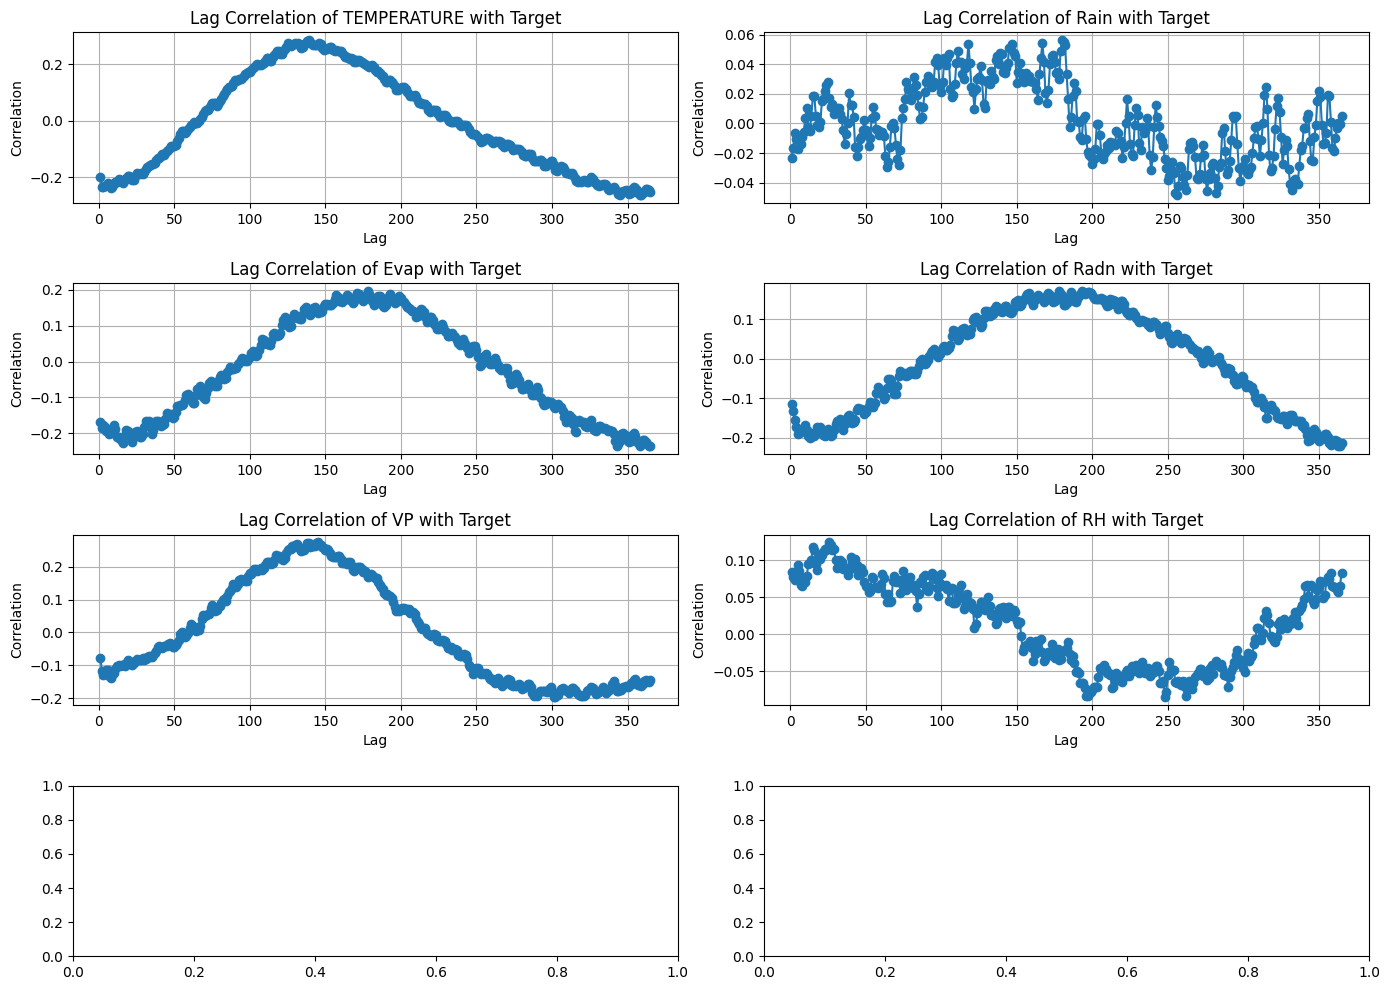

In [91]:
# Number of lags to compute
def getLagCorrelationMatrix(df):
    lagged_data = {}
    num_lags = 365
    targetvar = 'TOTALDEMAND'
    # Create lagged features for each feature and store in a dictionary
    features = ['TEMPERATURE', 'Rain', 'Evap', 'Radn', 'VP', 'RH']
    for feature in features:
        for lag in range(1, num_lags + 1):
            lagged_data[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

    # Concatenate all lagged features into a new DataFrame
    lagged_df = pd.concat(lagged_data, axis=1)

    # Drop NaN values caused by lagging
    lagged_df.dropna(inplace=True)
    df = df.loc[lagged_df.index]

    # Initialize a figure with 2x2 subplots
    fig, axes = plt.subplots(4, 2, figsize=(14, 10))
    # Loop through each feature and plot lagged correlations
    for i, feature in enumerate(features):
        # Calculate correlations for the current feature
        lagged_correlations = []
        for lag in range(1, num_lags + 1):
            correlation = lagged_df[f'{feature}_lag_{lag}'].corr(df[targetvar])
            lagged_correlations.append(correlation)
        
        print(f"maximum correlation at:{max(lagged_correlations):.2f}" +
              f" at lag of {lagged_correlations.index(max(lagged_correlations))} for feature: {feature}")
        # Get subplot axes
        ax = axes[i // 2, i % 2]
        # Plot the correlations
        ax.plot(range(1, num_lags + 1), lagged_correlations, marker='o')
        ax.set_title(f'Lag Correlation of {feature} with Target')
        ax.set_xlabel('Lag')
        ax.set_ylabel('Correlation')
        ax.grid(True)

getLagCorrelationMatrix(data)
plt.tight_layout()
plt.show()

In [65]:
# TODO: generate lag features using autocorrelation plots and correlation analysis
demandLagSteps = [1, 7, 14]
temperatureLagSteps = [1, 20, 30]
rainLagSteps = [15, 24]
evapLagSteps = [7, 15, 28]
radnLagSteps = [5, 16, 28]
rhLagSteps = [15, 26]

for lag in demandLagSteps:
    data[f'TOTALDEMAND_lag_{lag}'] = data['TOTALDEMAND'].shift(lag)

for lag in temperatureLagSteps:
    data[f'TEMPERATURE_lag_{lag}'] = data['TEMPERATURE'].shift(lag)

for lag in rainLagSteps:
    data[f'Rain_lag_{lag}'] = data['Rain'].shift(lag)

for lag in evapLagSteps:
    data[f'Evap_lag_{lag}'] = data['Evap'].shift(lag)

for lag in radnLagSteps:
    data[f'rand_lag_{lag}'] = data['Radn'].shift(lag)

for lag in rhLagSteps:
    data[f'rh_lag_{lag}'] = data['RH'].shift(lag)

print('\n'.join(data.columns))

DATETIME
TOTALDEMAND
TEMPERATURE
Rain
Evap
Radn
VP
RH
TOTALDEMAND_lag_1
TOTALDEMAND_lag_7
TOTALDEMAND_lag_14
TEMPERATURE_lag_1
TEMPERATURE_lag_20
TEMPERATURE_lag_30
Rain_lag_15
Rain_lag_24
Evap_lag_7
Evap_lag_15
Evap_lag_28
rand_lag_5
rand_lag_16
rand_lag_28
rh_lag_15
rh_lag_26


### Add date time variables

In [66]:
data['DAY'] = data['DATETIME'].dt.day_of_year
data['MONTH'] = data['DATETIME'].dt.month
data['YEAR'] = data['DATETIME'].dt.year
data[f'DAY_lag_250'] = data['DAY'].shift(250)
data[f'MONTH_lag_250'] = data['MONTH'].shift(250)

## Data summary before training

In [67]:
data.shape
data.dropna(inplace=True)

def getPreparedDataVersion(data, version):
    datacopy = data.copy(deep=True)

    if(version == "no lag features"):
        datacopy = datacopy.drop(columns=[col for col in datacopy.columns if 'lag' in col])

    return datacopy

#data = getPreparedDataVersion

features = data.drop(columns=['DATETIME', 'TOTALDEMAND'])
target = data['TOTALDEMAND']

features_numpy = features.to_numpy()

# scaledFeatureNames = [...]
# features_scaled[scaledFeatureNames] = scaler.fit_transform(features_numpy[scaledFeatureNames])

features_scaled = scaler.fit_transform(features_numpy)

print('\n'.join(features.columns))

TEMPERATURE
Rain
Evap
Radn
VP
RH
TOTALDEMAND_lag_1
TOTALDEMAND_lag_7
TOTALDEMAND_lag_14
TEMPERATURE_lag_1
TEMPERATURE_lag_20
TEMPERATURE_lag_30
Rain_lag_15
Rain_lag_24
Evap_lag_7
Evap_lag_15
Evap_lag_28
rand_lag_5
rand_lag_16
rand_lag_28
rh_lag_15
rh_lag_26
DAY
MONTH
YEAR
DAY_lag_250
MONTH_lag_250


In [68]:
data.describe()

,TOTALDEMAND,TEMPERATURE,Rain,Evap,Radn,VP,RH,TOTALDEMAND_lag_1,TOTALDEMAND_lag_7,TOTALDEMAND_lag_14,...,rand_lag_5,rand_lag_16,rand_lag_28,rh_lag_15,rh_lag_26,DAY,MONTH,YEAR,DAY_lag_250,MONTH_lag_250
count,"3,842.00","3,842.00","3,842.00","3,842.00","3,842.00","3,842.00","3,842.00","3,842.00","3,842.00","3,842.00",...,"3,842.00","3,842.00","3,842.00","3,842.00","3,842.00","3,842.00","3,842.00","3,842.00","3,842.00","3,842.00"
mean,"8,052.97",17.45,2.31,4.24,16.15,14.18,67.92,"8,053.51","8,055.37","8,058.63",...,16.15,16.14,16.13,67.91,67.88,183.99,6.55,"2,015.45",178.76,6.38
std,767.24,4.65,8.36,2.32,7.44,4.77,10.65,767.30,767.21,767.65,...,7.44,7.44,7.43,10.67,10.66,107.24,3.51,3.06,105.25,3.44
min,"6,043.80",6.44,0.00,0.30,1.00,4.00,19.70,"6,043.80","6,043.80","6,043.80",...,1.00,1.00,1.00,19.70,19.70,1.00,1.00,"2,010.00",1.00,1.00
25%,"7,528.48",13.53,0.00,2.40,10.60,10.20,62.95,"7,528.66","7,530.56","7,531.36",...,10.60,10.60,10.60,62.91,62.90,89.00,3.00,"2,013.00",88.00,3.00
50%,"8,000.69",17.64,0.00,3.80,14.90,13.80,69.30,"8,001.15","8,004.43","8,007.60",...,14.90,14.90,14.90,69.30,69.30,185.00,7.00,"2,015.00",175.00,6.00
75%,"8,571.18",21.14,0.40,5.80,21.70,18.00,74.45,"8,571.66","8,574.57","8,575.73",...,21.70,21.68,21.60,74.45,74.40,278.00,10.00,"2,018.00",270.00,9.00
max,"11,539.82",33.31,159.60,16.00,34.40,27.90,96.25,"11,539.82","11,539.82","11,539.82",...,34.40,34.40,34.40,96.25,96.25,366.00,12.00,"2,021.00",366.00,12.00


## Data splits

In [69]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, shuffle=False)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

## LSSVM Regression model training

In [70]:
# fit and predict
lssvm_model = LSSVMRegressor(gamma=0.1, kernel='rbf', sigma=10)
lssvm_model.fit(X_train, y_train)

## Test set

MAE: 236.28
Mean Squared Error (Regression): 93576.40
R^2 Score (Regression): 0.83
RMSE: 305.90
RRMSE: 0.04
Nash–Sutcliffe efficiency coefficient: -1326.03
Willmott index: 0.40
MAPE is: 10.15


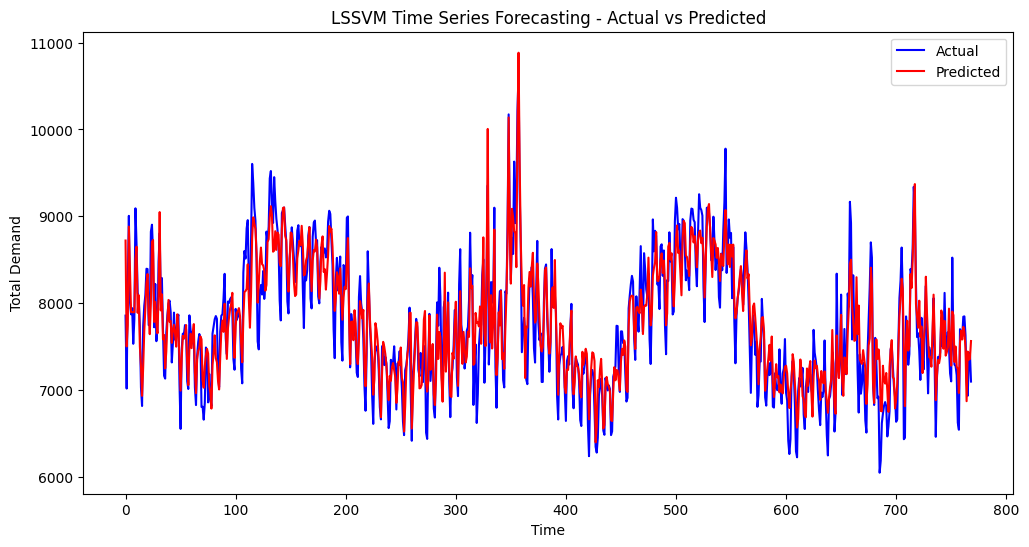

In [71]:
# fit and predict
lssvm_model = LSSVMRegressor(gamma=10, kernel='rbf', sigma=10)
lssvm_model.fit(X_train, y_train)
y_pred = lssvm_model.predict(X_test)
getEvaluationMetrics(y_test, y_pred, target)
getPlots(y_test, y_pred, residuals = False)

## Hyperparameter tuning with gridsearch

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters (Regression): {'gamma': 50, 'sigma': 10}
MAE: 230.28
Mean Squared Error (Regression): 88335.21
R^2 Score (Regression): 0.84
RMSE: 297.21
RRMSE: 0.04
Nash–Sutcliffe efficiency coefficient: -1369.31
Willmott index: 0.40
MAPE is: 10.29


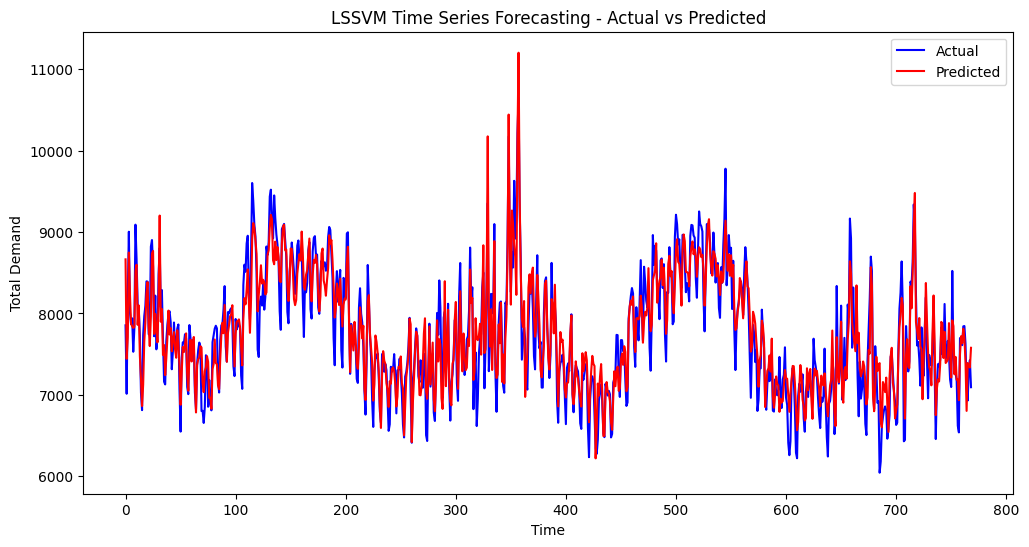

In [73]:
param_grid = {
    'gamma': [0.01, 0.1, 1, 10, 20, 30, 40, 50, 100],
    'sigma': [0.01, 0.1, 1, 10, 20, 30, 40, 50, 100]
}

grid_search = GridSearchCV(
    LSSVMRegressorWrapper(kernel='rbf'), 
    param_grid, cv=3, 
    scoring='neg_mean_absolute_percentage_error',
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best Parameters (Regression):", grid_search.best_params_)

# Evaluate with best parameters
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

getEvaluationMetrics(y_test, y_pred_best, target)
getPlots(y_test, y_pred_best, residuals=False)

## Validation set

MAE: 599.33
Mean Squared Error (Regression): 546935.57
R^2 Score (Regression): -0.46
RMSE: 739.55
RRMSE: 0.09
Nash–Sutcliffe efficiency coefficient: -0.46
Willmott index: 0.68
MAPE is: 8.38


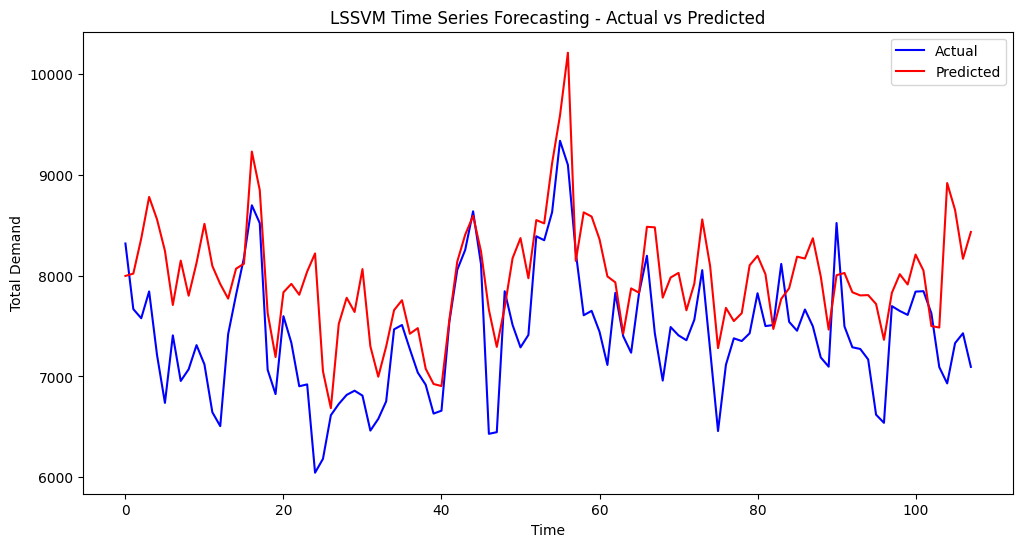

In [75]:
# "2020-12-01", "2021-03-18"
X_test_custom, y_test_custom = get_date_range_split(
    data, "2020-12-01", "2021-03-18", "TOTALDEMAND"
)
y_pred_custom = best_model.predict(X_test_custom)
getEvaluationMetrics(y_test_custom, y_pred_custom, target)
getPlots(y_test_custom, y_pred_custom)

# Other notes:

In [157]:
    # experiment more with lag features,
    # find more literature with existing lag features
    # provide reasoning
        # other people have done something
            # literature has shown that lag features are used in exisiting models
            # no access and SILO data lagging was not required in exisiting literature
        # experiment and testing
        # time constraints
    # discuss in future section
# Drop rows with NaN values introduced by lagging
